# Orders

📄 Notebook Introduction

- This notebook focuses on exploring the Orders dataset from Olist.
- Here, we analyze order delivery performance and customer review scores, and implement several order-related features inside the Order class (olist/order.py).

The notebook is structured as:

- Understanding the business context of orders

- Loading and exploring the dataset

- Implementing features step-by-step in the Order class

- Testing and validating the computed features





The goal is to create a DataFrame with the following features:


| feature_name 	| type 	| description 	|
|:---	|:---:	|:---	|
| `order_id` 	| str 	| the id of the order 	|
| `wait_time` 	| float 	| the number of days between order_purchase_timestamp and order_delivered_customer_date 	|
| `expected_wait_time` 	| float 	| the number of days between order_purchase_timestamp and estimated_delivery_date 	|
| `delay_vs_expected` 	| float 	| if the actual order_delivered_customer_date is later than the estimated delivery date, returns the number of days between the two dates, otherwise return 0 	|
| `order_status` 	| str 	| the status of the order 	|
| `dim_is_five_star` 	| int 	| 1 if the order received a five-star review, 0 otherwise 	|
| `dim_is_one_star` 	| int 	| 1 if the order received a one_star, 0 otherwise 	|
| `review_score` 	| int 	| from 1 to 5 	|
| `number_of_items` 	| int 	| number of items that the order contains 	|
| `number_of_sellers` 	| int 	| number of sellers involved in the order 	|
| `price` 	| float 	| total price of the order paid by customer 	|
| `freight_value` 	| float 	| value of the freight paid by customer 	|
| `distance_customer_seller` 	| float 	| the distance in km between customer and seller (optional) 	|  
  

In [3]:
# Auto reload imported module every time a jupyter cell is executed (handy for olist.order.py updates)
%load_ext autoreload
%autoreload 2

In [4]:
# Import usual modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
# Import olist data
from olist.data import Olist
olist = Olist()
data = olist.get_data()

In [7]:
data.keys()

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])

In [8]:
orders = data['orders'].copy() # good practice to be sure not to modify your `data` variable

assert(orders.shape == (99441, 8))

## 1. Code `order.py`

### a) `get_wait_time`
    ❓ Return a Dataframe with:
           order_id, wait_time, expected_wait_time, delay_vs_expected, order_status



> 1. Inspect the `orders` dataframe
2. Filter the dataframe on `delivered orders`
3. Handle `datetime`
    - Take time to understand what python [`datetime`](https://docs.python.org/3/library/datetime.html) objects are
    - and convert dates from "string" type to "pandas.datetime' using [`pandas.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)
4. Compute `wait_time` in days as a decimal number (starting from `order_purchase_timestamp`)
5. Compute `expected_wait_time` in days as a decimal number (starting from `order_purchase_timestamp`)
6. Compute `delay_vs_expected` in days as a decimal number (put `0` if the order is delivered earlier than estimated)
7. Check the new dataframe 
8. Once you are satisfied with your code, you can carefully copy-paste it from the notebook to to `olist/order.py`
9. Now try to load the data using your method in `orders.py`
10. Your code will probably not work straightaway
11. Make the necessary changes to make it work from inside a `.py` file

We want `wait_time`, `expected_wait_time` and `delay_vs_expected` in decimal numbers, not as integers. Think about it: a wait time of 8.1 or 8.9 days is a big difference. So you can't use Pandas' `dt.day` because that rounds both down to 8.


In [9]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [10]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [11]:
# handle datetime
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

In [12]:
orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']

0        8 days 10:28:40
1       13 days 18:46:08
2        9 days 09:27:40
3       13 days 05:00:36
4        2 days 20:58:23
              ...       
99436    8 days 05:13:56
99437   22 days 04:38:58
99438   24 days 20:37:34
99439   17 days 02:04:27
99440    7 days 16:11:00
Length: 99441, dtype: timedelta64[ns]

In [13]:
# Compute just the number of days in each time_delta
import datetime
one_day_delta = datetime.timedelta(days=1) # a "timedelta" object of 1 day

# Compute the columns that we need
# columns: wait_time, delay_vs_expected, expected_wait_time
orders.loc[:,'wait_time'] = \
    (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']) / one_day_delta

orders.loc[:,'delay_vs_expected'] = \
    (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']) / one_day_delta

orders.loc[:,'expected_wait_time'] = \
    (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']) / one_day_delta


In [14]:
# pandas method dt.days to compute time differences
(orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

0         8.0
1        13.0
2         9.0
3        13.0
4         2.0
         ... 
99436     8.0
99437    22.0
99438    24.0
99439    17.0
99440     7.0
Length: 99441, dtype: float64

In [15]:
# custom function to handle delay days
def handle_delay(x):
    if x > 0:
        return x
    else:
        return 0

orders.loc[:,'delay_vs_expected'] = orders['delay_vs_expected'].apply(handle_delay)

In [16]:
# check the result
orders[['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected']]

,order_id,wait_time,expected_wait_time,delay_vs_expected
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0
...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,8.218009,18.587442,0.0
99437,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.0
99438,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.0
99439,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0


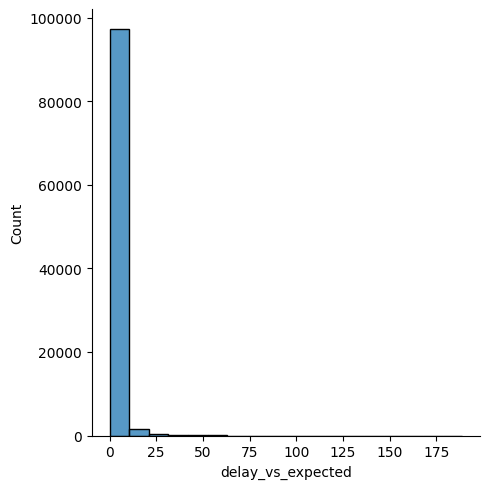

In [17]:
sns.displot(orders['delay_vs_expected'])

In [18]:
# Test code by using Order Class to get the dataframe
from olist.order import Order
Order().get_wait_time()

,order_id,order_purchase_timestamp,wait_time,expected_wait_time,delay_vs_expected,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,8.436574,15.544063,0.0,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,13.782037,19.137766,0.0,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,9.394213,26.639711,0.0,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,13.208750,26.188819,0.0,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2.873877,12.112049,0.0,delivered
...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,8.218009,18.587442,0.0,delivered
99437,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,22.193727,23.459051,0.0,delivered
99438,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,24.859421,30.384225,0.0,delivered
99439,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,17.086424,37.105243,0.0,delivered


### b) `get_review_score`
     ❓ Returns a DataFrame with:
        order_id, dim_is_five_star, dim_is_one_star, review_score

dim_is_$N$_star should contain `1` if review_score=$N$ and `0` otherwise 

<details>
    <summary markdown='span'>Hints</summary>

Think about `Series.map()` or `DataFrame.apply()`
    
</details>

In [19]:
reviews = data['order_reviews'].copy()
assert(reviews.shape == (99224,7))
reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [20]:
# Handle the category of review sore by using map() with a lamda function.
dim_is_one_star = lambda x: int(x==1)
dim_is_five_star = lambda x: int(x==5)
reviews["dim_is_five_star"] = reviews["review_score"].map(dim_is_five_star) # --> Series([0, 1, 1, 0, 0, 1 ...])
reviews["dim_is_one_star"] = reviews["review_score"].map(dim_is_one_star) # --> Series([0, 1, 1, 0, 0, 1 ...])

In [21]:
reviews[["order_id", "dim_is_five_star", "dim_is_one_star", "review_score"]]

,order_id,dim_is_five_star,dim_is_one_star,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,0,4
1,a548910a1c6147796b98fdf73dbeba33,1,0,5
2,f9e4b658b201a9f2ecdecbb34bed034b,1,0,5
3,658677c97b385a9be170737859d3511b,1,0,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,1,0,5
...,...,...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,1,0,5
99220,22ec9f0669f784db00fa86d035cf8602,1,0,5
99221,55d4004744368f5571d1f590031933e4,1,0,5
99222,7725825d039fc1f0ceb7635e3f7d9206,0,0,4


In [22]:
# move the code of notebook to Order class and get the data through object
from olist.order import Order
Order().get_review_score()

,order_id,dim_is_five_star,dim_is_one_star,review_score
0,73fc7af87114b39712e6da79b0a377eb,0,0,4
1,a548910a1c6147796b98fdf73dbeba33,1,0,5
2,f9e4b658b201a9f2ecdecbb34bed034b,1,0,5
3,658677c97b385a9be170737859d3511b,1,0,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,1,0,5
...,...,...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,1,0,5
99220,22ec9f0669f784db00fa86d035cf8602,1,0,5
99221,55d4004744368f5571d1f590031933e4,1,0,5
99222,7725825d039fc1f0ceb7635e3f7d9206,0,0,4


### c) `get_number_items`:
     ❓ Returns a DataFrame with:
        order_id, number_of_items (total number of items per order)

In [23]:
# get number of item per order id by using method chaining style
data["order_items"].groupby("order_id").count()\
    .rename(columns={"order_item_id": "number_of_items"})\
    .sort_values("number_of_items")[['number_of_items']]

,number_of_items
order_id,
00010242fe8c5a6d1ba2dd792cb16214,1
a6e9d106235bcf1dda54253686d89e99,1
a6e9b80a7636eb8dd592dbb3e20d0a91,1
a6e963c11e80432334e984ead4797a8b,1
a6e8ad5db31e71f5f12671af561acb4a,1
...,...
428a2f660dc84138d969ccd69a0ab6d5,15
9ef13efd6949e4573a18964dd1bbe7f5,15
1b15974a0141d54e36626dca3fdc731a,20


### d) `get_number_sellers`:
     ❓ Returns a DataFrame with:
        order_id, number_of_sellers (total number of unique sellers per order)
        
<details>
    <summary>▸ <i>Hint</i></summary>

`pd.Series.nunique()`
</details>

In [ ]:
 # `get_number_sellers`
 # Returns a DataFrame with: rder_id, number_of_sellers
 # (total number of unique sellers per order)
sellers = \
    data['order_items']\
    .groupby('order_id')['seller_id'].nunique().reset_index()

sellers.columns = ['order_id', 'number_of_sellers']
sellers.sort_values('number_of_sellers')

,order_id,number_of_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,1
65559,aaaf314a8cf0d0da71e52c6cd4184cbd,1
65558,aaaea350ff8a957595f3c631d6b63d1b,1
65557,aaae80f5b6239bd9e1b22e9aa542c3e8,1
65556,aaabf43feb9498d9de4588eb73231c25,1
...,...,...
11231,1d23106803c48c391366ff224513fb7f,4
53796,8c2b13adf3f377c8f2b06b04321b0925,4
55847,91be51c856a90d7efe86cf9d082d6ae3,4
79967,cf5c8d9f52807cb2d2f0a0ff54c478da,5


In [25]:
# Check your new dataframe and commit your code to olist/order.py when it works.
Order().get_number_sellers()

,order_id,number_of_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


In [26]:
# ### e) `get_price_and_freight`
# Returns a DataFrame with: order_id, price, freight_value
price_freight = \
    data['order_items']\
    .groupby('order_id',
             as_index=False).agg({'price': 'sum',
                                  'freight_value': 'sum'})
price_freight

,order_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72


## 2. All at once: `get_training_data`

❓ Time to code `get_training_data` making use of your previous coded methods, to gather all order features in one table

In [ ]:
# Get the features for traininng from previous method
Order().get_training_data()

,order_id,order_purchase_timestamp,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_items,number_of_sellers,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,9.394213,26.639711,0.0,delivered,1,0,5,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,13.208750,26.188819,0.0,delivered,1,0,5,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2.873877,12.112049,0.0,delivered,1,0,5,1,1,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96356,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,8.218009,18.587442,0.0,delivered,1,0,5,1,1,72.00,13.08
96357,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 12:58:58,22.193727,23.459051,0.0,delivered,0,0,4,1,1,174.90,20.10
96358,83c1379a015df1e13d02aae0204711ab,2017-08-27 14:46:43,24.859421,30.384225,0.0,delivered,1,0,5,1,1,205.99,65.02
96359,11c177c8e97725db2631073c19f07b62,2018-01-08 21:28:27,17.086424,37.105243,0.0,delivered,0,0,2,2,1,359.98,81.18


I got the dataframe with features which I need. I will use the feature to practice different regression model.